In [59]:
#####################################
### Import the relevant libraries ###
#####################################
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, accuracy_score, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
import pandas as pd
import sys
import os
from tensorflow import keras

# Add the src folder to Python path
sys.path.append(os.path.abspath('../src'))

# Now you can import your module
from data import load_data, load_embeddings, load_pca, prepare_data_for_training
from train import train_base, train_adversarial
from results import calculate_accuracy, calculate_perturbations_accuracy, calculate_cosine_perturbations_filtering

***
# **DATA**

In [60]:
#Specify dataset, path, encoding model, perturbation type etc and ensure that all data is regenerated
load_saved_embeddings = False
load_saved_align_mat = False
load_saved_pca = False
load_saved_perturbations = False
load_saved_hyperrectangles = False
from_logits = True

dataset_names = ['medical']
#written as dict to easily expand for other models - add in a few others
encoding_models = {'all-MiniLM-L6-v2': 'sbert22M'}
og_perturbation_name = 'original'
perturbation_names = ['character']
hyperrectangles_names = {'character': ['character']}

# Derived variables
dataset_name = dataset_names[0]
encoding_model = list(encoding_models.keys())[0]
encoding_model_name = encoding_models[encoding_model]
perturbation_name = perturbation_names[0]
hyperrectangles_name = list(hyperrectangles_names.keys())[0]
path=os.path.abspath('../datasets')


In [61]:
#Clean and embed dataset using ANTONIO tools

X_train_pos, X_train_neg, X_test_pos, X_test_neg, y_train_pos, y_train_neg, y_test_pos, y_test_neg = load_data(dataset_name, path=path)
data_cleaned = X_train_pos, X_train_neg, X_test_pos, X_test_neg, y_train_pos, y_train_neg, y_test_pos, y_test_neg
X_train_pos_embedded_o, X_train_neg_embedded_o, X_test_pos_embedded_o, X_test_neg_embedded_o, y_train_pos_o, y_train_neg_o, y_test_pos_o, y_test_neg_o = load_embeddings(dataset_name, encoding_model, encoding_model_name, og_perturbation_name, load_saved_embeddings, load_saved_align_mat, data_cleaned, path)
print(f'Train pos sentence embeddings shape: {X_train_pos_embedded_o.shape}')
print(f'Train neg sentence embeddings shape: {X_train_neg_embedded_o.shape}')
print(f'Test pos sentence embeddings shape: {X_test_pos_embedded_o.shape}')
print(f'Test neg sentence embeddings shape: {X_test_neg_embedded_o.shape}')

#note that output embeddings have already been rotated to principal axes but PCA not undertaken yet!

/Users/fleurconway/Documents/Programming/F21ZK_Verification_and_Validation/ANTONIO/src/data.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['query-label-expert'] = pos['query-label-expert'].replace({1: 0, 2: 0, 3: 0})
/Users/fleurconway/Documents/Programming/F21ZK_Verification_and_Validation/ANTONIO/src/data.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg['query-label-expert'] = neg['query-label-expert'].replace({0: 1})


(989, 384)
Train pos sentence embeddings shape: (989, 384)
Train neg sentence embeddings shape: (1052, 384)
Test pos sentence embeddings shape: (424, 384)
Test neg sentence embeddings shape: (451, 384)


Visualise dataset

In [62]:
#Quick look at actual strings
# Show the first 5 rows of medical queries (X_train_pos)
for i in range(3):
    print(f"Label: {y_train_pos[i]} | Sentence: {X_train_pos[i]}")
for i in range(3):
    print(f"Label: {y_train_neg[i]} | Sentence: {X_train_neg[i]}")

Label: 0 | Sentence: Why do i get a bad headache when i don't eat enough during the day?
Label: 0 | Sentence: What causes heart rate to suddenly quicken to 100 resting after pressure on back for a while - with difficulty breathing?
Label: 0 | Sentence: peritonsillar abscess drainage aftercare.. please help
Label: 1.0 | Sentence: If humans were not restrained by the obstetrical dilemma, how many weeks, on average, would a fetus take to naturally gestate inside the womb before birth, and and how large would it get?
Label: 1.0 | Sentence: Writer with a question: What kind of medical situations do you have to inform the police about?
Label: 1.0 | Sentence: Reddit, I need your help making a decision.


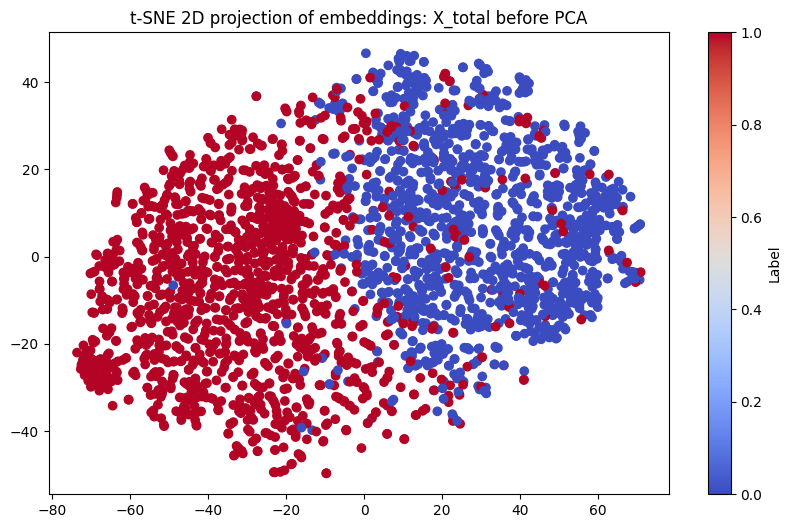

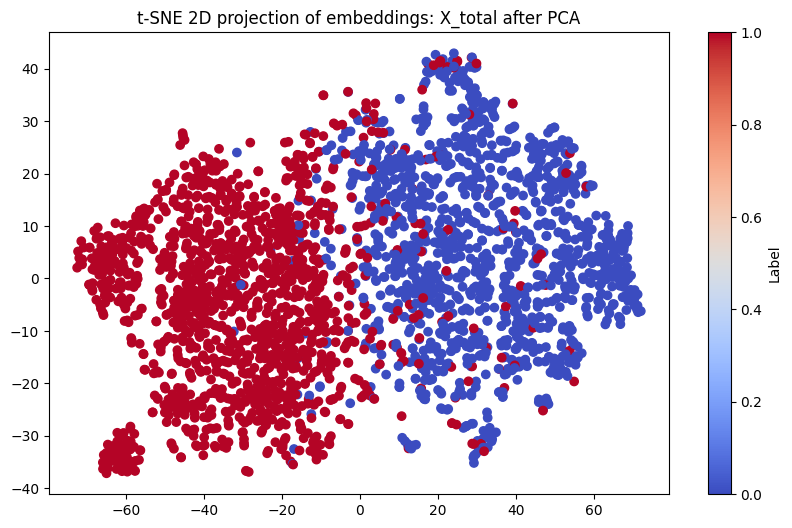

In [63]:
#for visualisation I consulted the paper: Li et al. - 2016 - Visualizing and Understanding Neural Models in NLP
#this lists 60dheatmaps for representation of selected words/phrases/sentences
#it also refers to t-sne (Maaten and Hinton - 2008 - Visualizing Data using t-SNE) which comes in scikit-learn
#interesting to do this both before and after PCA. before PCA to show gauge semantic meaning in the structure and after to see how the dimensionality reduction and alignment changes this 


#need to concatenate data in order to visualise clusters - don't use ANTONIO function for this as batches the training and test data
X_total_before_PCA = np.concatenate((X_train_pos_embedded_o, X_train_neg_embedded_o, X_test_pos_embedded_o, X_test_neg_embedded_o), axis=0)
y_total= np.concatenate((y_train_pos_o, y_train_neg_o, y_test_pos_o, y_test_neg_o), axis=0)


def display_some_examples(X_data, y_data, n_examples= None, X_name = "X_data"):
    tsne = TSNE(n_components=2, random_state=42)
    examples_2d = tsne.fit_transform(X_data)

    plt.figure(figsize=(10,6))
    plt.scatter(examples_2d[:n_examples,0], examples_2d[:n_examples,1], c=y_data[:n_examples], cmap='coolwarm')
    plt.colorbar(label='Label')
    plt.title(f"t-SNE 2D projection of embeddings: {X_name}")
    plt.show()

display_some_examples(X_total_before_PCA, y_total, n_examples=None, X_name = "X_total before PCA")

#now do the same but after PCA! note that PCA components selected as 30
n_components = 30
X_train_pos, X_train_neg, X_test_pos, X_test_neg = load_pca(dataset_name, encoding_model_name, load_saved_pca, X_train_pos_embedded_o, X_train_neg_embedded_o, X_test_pos_embedded_o, X_test_neg_embedded_o, n_components, path=path)
X_total_after_PCA = np.concatenate((X_train_pos, X_train_neg, X_test_pos, X_test_neg), axis=0)
display_some_examples(X_total_after_PCA, y_total, n_examples=None, X_name = "X_total after PCA")


In [ ]:
# import umap

# reducer = umap.UMAP(n_components=2, random_state=42)
# X_emb_2d = reducer.fit_transform(X_embeddings_train)

# plt.figure(figsize=(10, 8))
# scatter = plt.scatter(X_emb_2d[:, 0], X_emb_2d[:, 1], c=y_train, cmap='coolwarm', alpha=0.7)
# plt.legend(*scatter.legend_elements(), title="Labels")
# plt.title("UMAP 2D projection of sentence embeddings")
# plt.show()

# from sklearn.metrics.pairwise import cosine_similarity

# n_queries = 3
# random_indices = np.random.choice(len(X_embeddings_train), size=n_queries, replace=False)

# for query_idx in random_indices:
#     query_vec = X_embeddings_train[query_idx]

#     # Compute cosine similarity with all embeddings
#     sim_scores = cosine_similarity([query_vec], X_embeddings_train)[0]

#     # Get top 5 most similar sentences (excluding the query itself)
#     closest_idx = np.argsort(sim_scores)[-6:]  
#     closest_idx = closest_idx[closest_idx != query_idx]  # remove the query itself

#     # Print results
#     print(f"\nQuery sentence: {X_train[query_idx]}")
#     print("Top similar sentences:")
#     for idx in closest_idx[::-1]:
#         print(f"- {X_train[idx]} (label={y_train[idx]}, similarity={sim_scores[idx]:.3f})")

# import seaborn as sns

# # ---- Sample a subset ----
# num_samples = 20  # pick how many sentences to visualize
# subset_idx = np.random.choice(len(X_embeddings_train), num_samples, replace=False)
# subset_embeddings = X_embeddings_train[subset_idx]
# subset_sentences = X_train[subset_idx]

# # ---- Compute cosine similarity ----
# sim_matrix = cosine_similarity(subset_embeddings)

# # ---- Prepare labels for the heatmap ----
# # Use first ~6-10 words of each sentence for readability
# subset_labels = [(" ".join(s.split()[:6]) + "...") if len(s.split()) > 6 else s for s in subset_sentences]

# # ---- Plot the heatmap ----
# plt.figure(figsize=(12, 10))
# sns.heatmap(sim_matrix, annot=True, fmt=".2f", cmap='viridis', xticklabels=subset_labels, yticklabels=subset_labels)
# plt.title("Cosine similarity heatmap of SBERT embeddings")
# plt.xticks(rotation=45, ha='right')
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()

In [64]:
# import umap
# from sklearn.cluster import KMeans

# reducer = umap.UMAP(n_components=2, random_state=42)
# X_emb_2d = reducer.fit_transform(X_embeddings_train)

# plt.figure(figsize=(10, 8))
# scatter = plt.scatter(X_emb_2d[:, 0], X_emb_2d[:, 1], c=y_train, cmap='coolwarm', alpha=0.7)
# plt.legend(*scatter.legend_elements(), title="Labels")
# plt.title("UMAP 2D projection of sentence embeddings")
# plt.show()

# # --- Create DataFrame with coordinates and labels ---
# umap_df = pd.DataFrame(X_emb_2d, columns=['UMAP1', 'UMAP2'])
# umap_df['label'] = y_train

# # --- Cluster the UMAP points ---
# kmeans = KMeans(n_clusters=2, random_state=42)
# umap_df['cluster'] = kmeans.fit_predict(X_emb_2d)


# # --- Find misclustered points (label != cluster) ---
# misclustered = umap_df[umap_df['label'] != umap_df['cluster']]

# print(f"Number of misclustered points: {len(misclustered)}\n")

# # --- Inspect the misclustered sentences ---
# mis_idx = misclustered.index
# for i in mis_idx[:20]:  # show first 10 for brevity
#     print(f"Label: {y_train[i]}, Cluster: {umap_df.loc[i, 'cluster']}")
#     print(f"Sentence: {X_train[i]}")
#     print("---")

# from sklearn.metrics import silhouette_score


# # --- Cluster in high-D space ---
# kmeans_hd = KMeans(n_clusters=2, random_state=42)
# clusters_hd = kmeans_hd.fit_predict(X_embeddings_train)

# # --- Compute silhouette score ---
# score = silhouette_score(X_embeddings_train, clusters_hd, metric='cosine')  # cosine is better for embeddings
# print(f"Silhouette Score (high-D embeddings): {score:.4f}")



the silhouette score being near 0 indicates overlapping clusters in high dimensional space (-1 is worst value, 1 is best value)

***
# **BASE TRAINING**

In [ ]:
##########################
### Set some variables and train###
##########################

input_size = n_components  # e.g., 384 for SBERT but reduced by PCA to 30
batch_size = 64 # as used in ANTONIO
epochs = 30 #as used in ANTONIO
n_classes = 2 #binary classification
epsilon = 0.3 #from lab code
alpha = 0.1 #from lab code
num_iter = 10 #from lab code

#from ANTONIO code
# n_components = 30
# batch_size = 64
seed = 42
# epochs = 30
# pgd_steps = 5 


In [51]:
########################
### Define the model ###
########################
# could add more or denser layers (dense(256)) or switch to CNN,  or try softmax for multi-class, or add regularisation
#Marco's paper says they train a medium-sized fully-connected DNN (with 2 layers of size (128, 2) and input size 30) using stochastic gradient descent and cross-entropy loss
#from Marcos ANTONIO code
def get_model(n_components):
    inputs = keras.Input(shape=(n_components,), name="embeddings")
    x = keras.layers.Dense(128, activation="relu", name="dense_1")(inputs)
    outputs = keras.layers.Dense(2, activation="linear", name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    print(model.summary())
    return model

#my previous attempts:
# def get_model(input_size):
#     initializer = tf.keras.initializers.GlorotUniform(seed=42)
#     model = tf.keras.Sequential([
#             tf.keras.layers.Input(shape=(input_size,), name='input_features'),
#             tf.keras.layers.Dense(128, activation='relu', kernel_initializer=initializer, name='dense_1'),
#             tf.keras.layers.Dense(2, activation='softmax', kernel_initializer=initializer, name='output_layer')
#         ])
#     print(model.summary())
#     return model

### supposedly fine with sigmoid and one output but makes no sense to me
# def get_model(input_size):
#     initializer = tf.keras.initializers.GlorotUniform(seed=42)
#     model = tf.keras.Sequential([
#             tf.keras.layers.Input(shape=(input_size,), name='input_features'),
#             tf.keras.layers.Dense(128, activation='relu', kernel_initializer=initializer, name='dense_1'),
#             tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=initializer, name='output_layer')
#         ])
#     print(model.summary())
#     return model

In [56]:
##########################
### Train a base model ###
##########################

#try to use ANTONIO fields here
# Prepare the data for training, already did first line but run again to be careful
X_train_pos, X_train_neg, X_test_pos, X_test_neg = load_pca(dataset_name, encoding_model_name, load_saved_pca, X_train_pos_embedded_o, X_train_neg_embedded_o, X_test_pos_embedded_o, X_test_neg_embedded_o, n_components, path=path)
train_dataset, test_dataset = prepare_data_for_training(X_train_pos, X_train_neg, X_test_pos, X_test_neg, y_train_pos_o, y_train_neg_o, y_test_pos_o, y_test_neg_o, batch_size)

# Train and save the base model
model_path = f'{path}/{dataset_name}/models/tf/{encoding_model_name}'
if not os.path.exists(model_path):
    os.makedirs(model_path)
n_samples = int(len(X_train_pos))

model = get_model(n_components)
model = train_base(model, train_dataset, test_dataset, epochs, seed=seed, from_logits=from_logits)
model.save(f'{model_path}/base_{seed}')

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddings (InputLayer)     [(None, 30)]              0         
                                                                 
 dense_1 (Dense)             (None, 128)               3968      
                                                                 
 predictions (Dense)         (None, 2)                 258       
                                                                 
Total params: 4226 (16.51 KB)
Trainable params: 4226 (16.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

Epoch 1
Train acc: 0.9084, Train loss: 0.5977 --- Test acc: 0.9154, Test loss: 0.6025 --|-- Time: 0.25s

Epoch 2
Train acc: 0.9383, Train loss: 0.5015 --- Test acc: 0.9417, Test loss: 0.5085 --|-- Time: 0.23s

Epoch 3
Train acc: 0.9397, Train loss: 0.3962 --- Test acc: 0.9394, Test loss: 0.4050 --|-- Time: 0.23s

Epoch 4
Train acc: 0.9417, Train loss: 0.3051 --- Test acc: 0.9406, Test loss: 0.3132 --|-- Time: 0.23s

Epoch 5
Train acc: 0.9427, Train loss: 0.2449 --- Test acc: 0.9394, Test loss: 0.2514 --|-- Time: 0.23s

Epoch 6
Train acc: 0.9446, Train loss: 0.2086 --- Test acc: 0.9394, Test loss: 0.2139 --|-- Time: 0.23s

Epoch 7
Train acc: 0.9481, Train loss: 0.1874 --- Test acc: 0.9383, Test loss: 0.1911 --|-- Time: 0.23s

Epoch 8
Train acc: 0.9476, Train loss: 0.1744 --- Test acc: 0.9371, Test loss: 0.1768 --|-- Time: 0.22s

Epoch 9
Train acc: 0.9486, Train loss: 0.1656 --- Test acc: 0.9383, Test loss: 0.1677 --|-- Time: 0.22s

Epoch 10
Train acc: 0.9486, Train loss: 0.1600 --

INFO:tensorflow:Assets written to: /Users/fleurconway/Documents/Programming/F21ZK_Verification_and_Validation/ANTONIO/datasets/medical/models/tf/sbert22M/base_42/assets


INFO:tensorflow:Assets written to: /Users/fleurconway/Documents/Programming/F21ZK_Verification_and_Validation/ANTONIO/datasets/medical/models/tf/sbert22M/base_42/assets


In [57]:
def print_metrics(model, x, y, n_classes):
    """
    Print accuracy, precision, recall, F1, and plot ROC curves.
    Works for both binary and multiclass classification.
    """
    # Predict probabilities
    y_pred_prob = model.predict(x)
    
    # Predicted class labels
    y_pred_class = np.argmax(y_pred_prob, axis=1)
    
    # Accuracy, Precision, Recall, F1
    accuracy = accuracy_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class, average='macro')
    recall = recall_score(y, y_pred_class, average='macro')
    f1 = f1_score(y, y_pred_class, average='macro')
    
    print("=== Classification Metrics ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print(f"F1-score (macro): {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y, y_pred_class))
    
    # ROC curve
    plt.figure(figsize=(6, 5))
    
    if n_classes == 2:
        # Binary classification
        fpr, tpr, _ = roc_curve(y, y_pred_prob[:, 1])
        auc_score = roc_auc_score(y, y_pred_prob[:, 1])
        plt.plot(fpr, tpr, label=f'Class 1 (AUC = {auc_score:.2f})')
    else:
        # Multiclass
        y_bin = label_binarize(y, classes=np.arange(n_classes))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_bin[:, i], y_pred_prob[:, i])
            auc_score = roc_auc_score(y_bin[:, i], y_pred_prob[:, i])
            plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddings (InputLayer)     [(None, 30)]              0         
                                                                 
 dense_1 (Dense)             (None, 128)               3968      
                                                                 
 predictions (Dense)         (None, 2)                 258       
                                                                 
Total params: 4226 (16.51 KB)
Trainable params: 4226 (16.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
(None, 30)
(None, 2)
(2916, 30)
92/92 [==============================] - 0s 343us/step
=== Classification Metrics ===
Accuracy: 0.4698
Precision (macro): 0.4337
Recall (macro): 0.4831
F1-score (macro): 0.3587

Classification Report:
              precision    recall  f1-score   suppo

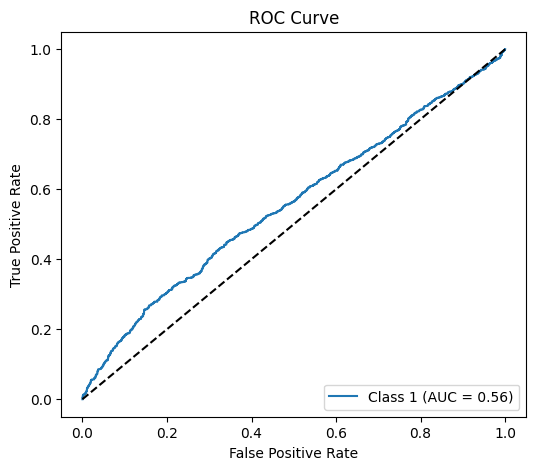

In [58]:
#####################################################
### Calculate precision, recall, F1 and ROC curve ###
#####################################################
#requires information from inside train_base function in ANTONIO pipeline so lets pull this out here, not batching?
model_base = get_model(input_size)
# optimizer = keras.optimizers.Adam()
# loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits)
# accuracy_fn = tf.keras.metrics.SparseCategoricalAccuracy()
# model_base.compile(optimizer=optimizer, loss=loss_fn, metrics=[accuracy_fn])
# model_base.fit(train_dataset, epochs=epochs, validation_data=test_dataset,)

print(model_base.input_shape)
print(model_base.output_shape)
print(X_total_after_PCA.shape)

print_metrics(model_base, X_total_after_PCA, y_total, n_classes)

In [11]:
######################################
### Define the PGD attack function ###
######################################

def pgd_attack(model, x, y, epsilon, alpha, num_iter):
    """Perform PGD attack on a batch of images.
    
    Args:
        model: Trained Keras model.
        x: Input images (batch).
        y: True labels (batch).
        epsilon: Maximum perturbation.
        alpha: Step size for each iteration.
        num_iter: Number of PGD iterations.

    Returns:
        Adversarial examples.
    """
    # Make a copy of the input to avoid modifying the original data
    x_adv = tf.identity(x)

    # Iterate PGD for num_iter steps
    for i in range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)  # Watch x_adv for gradient computation
            predictions = model(x_adv)  # Forward pass
            loss = tf.keras.losses.sparse_categorical_crossentropy(y, predictions)  # Loss w.r.t. true label

        # Compute the gradients of the loss w.r.t. the input
        gradients = tape.gradient(loss, x_adv)
        
        # Perform gradient ascent step in the direction that maximizes the loss
        perturbations = tf.sign(gradients)  # Use the sign of the gradients (FGSM-like step)
        x_adv = x_adv + alpha * perturbations  # Update the adversarial example
        
        # Project the adversarial example to ensure it's within epsilon-ball of the original image
        x_adv = tf.clip_by_value(x_adv, x - epsilon, x + epsilon)
        
        # Ensure the adversarial examples are within the valid input range [0, 1]
        x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)
    
    return x_adv

In [ ]:
### from ANTONIO
def train_adversarial(model, train_dataset, test_dataset, hyperrectangles, epochs, batch_size, n_samples, pgd_steps, alfa=1, beta=1, eps_multiplier=1000, seed=None, from_logits=False):
    if seed:
        tf.random.set_seed(seed)
        np.random.seed(seed)

    optimizer = keras.optimizers.Adam()
    ce_batch_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits)
    pgd_batch_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits)
    pgd_attack_single_image_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits)

    train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
    test_acc_metric = keras.metrics.SparseCategoricalAccuracy()
    train_loss_metric = keras.metrics.SparseCategoricalCrossentropy(from_logits=from_logits)
    test_loss_metric = keras.metrics.SparseCategoricalCrossentropy(from_logits=from_logits)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}")
        start_time = time.time()

        # Iterate over the batches of the dataset.
        for x_batch_train, y_batch_train in train_dataset:
            # Open a GradientTape to record the operations run during the forward pass, which enables auto-differentiation.
            with tf.GradientTape() as tape:
                outputs = model(x_batch_train, training=True)  # Outputs for this minibatch
                ce_loss_value = ce_batch_loss(y_batch_train, outputs)
                ce_loss_value = ce_loss_value * alfa
            # Use the gradient tape to automatically retrieve the gradients of the trainable variables with respect to the loss.
            grads = tape.gradient(ce_loss_value, model.trainable_weights)
            # Run one step of gradient descent by updating the value of the variables to minimize the loss.
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        #########################################PGD####################################################
        pgd_dataset = []
        np.random.shuffle(hyperrectangles)
        for hyperrectangle in hyperrectangles[:n_samples]:
            t_hyperrectangle = np.transpose(hyperrectangle)

            # Calculate the epsilon for each dimension as ((dim[1] - dim[0]) / (pgd_steps * eps_multiplier))
            eps = []
            for d in hyperrectangle:
                eps.append((d[1] - d[0]) / (pgd_steps * eps_multiplier))
            
            # Generate a pgd point from the hyperrectangle 
            pgd_point = []
            for d in hyperrectangle:
                pgd_point.append(np.random.uniform(d[0], d[1]))
            # PGD attack on the image
            pgd_point = tf.convert_to_tensor([pgd_point], dtype=tf.float32)
            label_0 = tf.convert_to_tensor([[0]], dtype=tf.float32)
            for pgd_step in range(pgd_steps):
                with tf.GradientTape() as tape:
                    tape.watch(pgd_point)
                    prediction = model(pgd_point, training=False)
                    pgd_single_image_loss = pgd_attack_single_image_loss(label_0, prediction)
                # Get the gradients of the loss w.r.t to the input image.
                gradient = tape.gradient(pgd_single_image_loss, pgd_point)
                # Get the sign of the gradients to create the perturbation
                signed_grad = tf.sign(gradient)
                pgd_point = pgd_point + signed_grad * eps
                pgd_point = tf.clip_by_value(pgd_point, t_hyperrectangle[0], t_hyperrectangle[1])
                # print(f"PGD step: {pgd_step + 1}", end="\r")

            # Concatenate the pgd points
            if len(pgd_dataset) > 0:
                pgd_dataset = np.concatenate((pgd_dataset, pgd_point), axis=0)
            else:
                pgd_dataset = pgd_point

        pgd_dataset = np.asarray(pgd_dataset)
        pgd_labels_inside = np.full(len(pgd_dataset), 0)

        # Convert the pgd generated inputs into tf datasets, shuffle and batch them
        pgd_dataset = tf.data.Dataset.from_tensor_slices((pgd_dataset, pgd_labels_inside))
        pgd_dataset = pgd_dataset.shuffle(buffer_size=1024).batch(batch_size)

        # Iterate over the batches of the pgd dataset.
        for x_batch_train, y_batch_train in pgd_dataset:
            # Open a GradientTape to record the operations run during the forward pass, which enables auto-differentiation.
            with tf.GradientTape() as tape:
                outputs = model(x_batch_train, training=True)  # Outputs for this minibatch
                pgd_loss_value = pgd_batch_loss(y_batch_train, outputs)
                pgd_loss_value = pgd_loss_value * beta
            # Use the gradient tape to automatically retrieve the gradients of the trainable variables with respect to the loss.
            grads = tape.gradient(pgd_loss_value, model.trainable_weights)
            # Run one step of gradient descent by updating the value of the variables to minimize the loss.
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
        ################################################################################################
        
        # Run a training loop at the end of each epoch.
        for x_batch_train, y_batch_train in train_dataset:
            train_outputs = model(x_batch_train, training=False)
            train_acc_metric.update_state(y_batch_train, train_outputs)
            train_loss_metric.update_state(y_batch_train, train_outputs)

        # Run a testing loop at the end of each epoch.
        for x_batch_test, y_batch_test in test_dataset:
            test_outputs = model(x_batch_test, training=False)
            test_acc_metric.update_state(y_batch_test, test_outputs)
            test_loss_metric.update_state(y_batch_test, test_outputs)

        train_acc = train_acc_metric.result()
        test_acc = test_acc_metric.result()
        train_loss = train_loss_metric.result()
        test_loss = test_loss_metric.result()

        train_acc_metric.reset_states()
        test_acc_metric.reset_states()
        train_loss_metric.reset_states()
        test_loss_metric.reset_states()

        print(f"Train acc: {float(train_acc):.4f}, Train loss: {float(train_loss):.4f} --- Test acc: {float(test_acc):.4f}, Test loss: {float(test_loss):.4f} --- Time: {(time.time() - start_time):.2f}s")

    return model


We need to conduct perturbations of the sentences - using moradi for example https://github.com/mmoradi-iut/NLP-perturbation
and vicuna and/or other types of perturbation methods

also are complete scripts available on ANTONIO toolbox with perturbations and definitions of hyper-rectangles https://github.com/ANTONIONLP/ANTONIO/tree/main

In [12]:
############################################################################
### Define the function to visualize the original and adversarial images ###
############################################################################

def original_vs_adversarial_images(x_og, y_og, x_adv, y_pred):
    plt.figure(figsize=(17, 4))

    # Counter for how many images to display
    display_count = 0

    for i in range(len(x_og)):
        # Check if the class changes after the attack
        if y_og[i] != y_pred[i]:
            # Original images (reshape from (28, 28, 1) to (28, 28))
            original_image = x_og[i].reshape(28, 28)
            
            # Adversarial images (reshape from (28, 28, 1) to (28, 28))
            adversarial_image = x_adv[i].numpy().reshape(28, 28)

            # Plot original images
            plt.subplot(2, 10, display_count + 1)
            plt.imshow(original_image, cmap='gray')
            plt.axis('off')
            plt.title(f'Orig: {y_og[i]}')

            # Plot adversarial images
            plt.subplot(2, 10, display_count + 11)
            plt.imshow(adversarial_image, cmap='gray')
            plt.axis('off')
            plt.title(f'Adv: {y_pred[i]}')

            # Increment the display counter
            display_count += 1
            
            # Stop after displaying 10 images
            if display_count == 10:
                break

    plt.tight_layout()
    plt.show()

In [13]:
####################################################################################
### Attack the model using PGD and visualize the original and adversarial images ###
####################################################################################

# Test the PGD attack
x_test_sample = X_embeddings_test
y_test_sample = y_test

# Generate adversarial examples
x_test_adv = pgd_attack(model_base, x_test_sample, y_test_sample, epsilon=epsilon, alpha=alpha, num_iter=num_iter)

# Evaluate the model on the adversarial examples
y_pred_adv = np.argmax(model_base.predict(x_test_adv), axis=1)
accuracy_adv = np.mean(y_pred_adv == y_test_sample)

print(f'Accuracy on adversarial examples: {accuracy_adv:.4f}')
original_vs_adversarial_images(x_test_sample, y_test_sample, x_test_adv, y_pred_adv)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
Accuracy on adversarial examples: 0.0000


ValueError: cannot reshape array of size 384 into shape (28,28)

<Figure size 1700x400 with 0 Axes>

***
# **ADVERSARIAL TRAINING**

In [25]:
################################################
### Define the adversarial training function ###
################################################

def adversarial_training(model, train_dataset, optimizer, loss_fn, epsilon, alpha, num_iter, epochs):
    """
    Performs adversarial training with PGD adversarial examples.
    
    Args:
    model: The model to train.
    train_dataset: A TensorFlow dataset for training.
    optimizer: The optimizer for model training.
    loss_fn: Loss function to use.
    epsilon: Maximum perturbation for PGD (epsilon).
    alpha: Step size for PGD.
    num_iter: Number of PGD iterations for generating adversarial examples.
    epochs: Number of training epochs.
    
    Returns:
    model: The trained model.
    """
    for epoch in range(epochs):
        start_time = time.time()  # Record start time for the epoch
        print(f"Epoch {epoch + 1}/{epochs}")

        # Accuracy metric for the epoch
        train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
        
        # Training loop over batches
        for step, (x_batch, y_batch) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                # Generate adversarial examples using PGD
                x_adv_batch = pgd_attack(model, x_batch, y_batch, epsilon=epsilon, alpha=alpha, num_iter=num_iter)
                
                # Combine original and adversarial examples for training
                combined_x = tf.concat([x_batch, x_adv_batch], axis=0)
                combined_y = tf.concat([y_batch, y_batch], axis=0)
                
                # Forward pass
                logits = model(combined_x, training=True)
                
                # Compute the loss
                loss = loss_fn(combined_y, logits)
            
            # Backpropagation
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # Update training accuracy metric
            train_acc_metric.update_state(combined_y, logits)

        # End of epoch: calculate and print accuracy and epoch time
        train_acc = train_acc_metric.result().numpy()

        # Evaluate on test dataset (for validation accuracy)
        test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
        for x_test_batch, y_test_batch in test_dataset:
            test_logits = model(x_test_batch, training=False)
            test_acc_metric.update_state(y_test_batch, test_logits)
        test_acc = test_acc_metric.result().numpy()

        print(f"Train loss: {loss.numpy():.4f} -|- Train acc: {train_acc:.4f} -|- Test acc: {test_acc:.4f} -|- Time: {(time.time() - start_time):.2f}s")
    
    return model

In [26]:
##################################
### Train an adversarial model ###
##################################

optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model_adv = get_model(input_size)
model_adv = adversarial_training(model_adv, train_dataset, optimizer, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=num_iter, epochs=epochs)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/6


2025-09-16 20:51:14.392380: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-09-16 20:51:14.801875: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train loss: 0.1367 -|- Train acc: 0.8585 -|- Test acc: 0.9458 -|- Time: 74.95s
Epoch 2/6


2025-09-16 20:52:30.796347: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train loss: 0.2838 -|- Train acc: 0.9302 -|- Test acc: 0.9637 -|- Time: 75.99s
Epoch 3/6
Train loss: 0.1352 -|- Train acc: 0.9452 -|- Test acc: 0.9707 -|- Time: 76.64s
Epoch 4/6


2025-09-16 20:55:04.364581: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train loss: 0.1291 -|- Train acc: 0.9541 -|- Test acc: 0.9719 -|- Time: 76.93s
Epoch 5/6
Train loss: 0.0425 -|- Train acc: 0.9601 -|- Test acc: 0.9747 -|- Time: 77.05s
Epoch 6/6
Train loss: 0.0449 -|- Train acc: 0.9639 -|- Test acc: 0.9760 -|- Time: 76.79s


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step
Accuracy: 0.9760
Precision (macro): 0.9757
Recall (macro): 0.9759
F1-score (macro): 0.9757


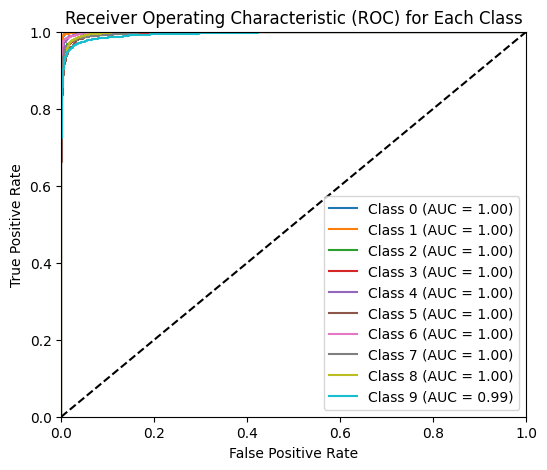

In [27]:
#####################################################
### Calculate precision, recall, F1 and ROC curve ###
#####################################################

print_metrics(model_adv, X_test, y_test, n_classes)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
Accuracy on adversarial examples: 0.9405


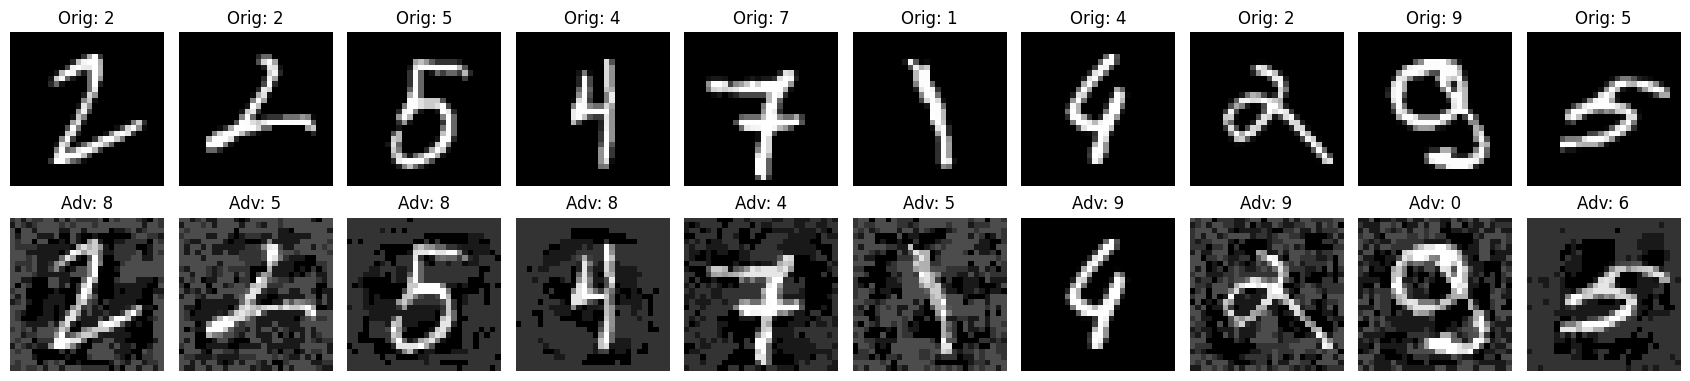

In [28]:
####################################################################################
### Attack the model using PGD and visualize the original and adversarial images ###
####################################################################################

# Test the PGD attack
x_test_sample_ADV = X_test
y_test_sample_ADV = y_test

# Generate adversarial examples
x_test_adv_ADV = pgd_attack(model_adv, x_test_sample_ADV, y_test_sample_ADV, epsilon=epsilon, alpha=alpha, num_iter=num_iter)

# Evaluate the model on the adversarial examples
y_pred_adv_ADV = np.argmax(model_adv.predict(x_test_adv_ADV), axis=1)
accuracy_adv_ADV = np.mean(y_pred_adv_ADV == y_test_sample_ADV)

print(f'Accuracy on adversarial examples: {accuracy_adv_ADV:.4f}')
original_vs_adversarial_images(x_test_sample_ADV, y_test_sample_ADV, x_test_adv_ADV, y_pred_adv_ADV)

In [29]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Initialize explainer
explainer = lime_image.LimeImageExplainer()

# Pick a test image to explain
i = 0
image = X_test[i]  # shape (28,28)
label = y_test[i]

# LIME expects 3-channel images; MNIST is grayscale
image_3ch = np.stack([image]*3, axis=-1)

# Explain the image
explanation = explainer.explain_instance(
    image_3ch,
    classifier_fn=lambda x: model_adv.predict(x.reshape(-1, input_size).astype('float32')),
    top_labels=3,
    hide_color=0,
    num_samples=1000
)

# Get superpixel explanation for top predicted class
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

# Display
plt.imshow(mark_boundaries(temp, mask))
plt.title(f'True label: {label}, Predicted: {np.argmax(model_adv.predict(image_3ch.reshape(1,-1)))}')
plt.axis('off')
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ValueError: Found input variables with inconsistent numbers of samples: [1000, 9000]